# Projeto IATUR - Índice de Atividades Turísticas

---

A IATUR integra a PMS (Pesquisa Mensal de Serviços do IBGE) e é uma pesquisa de amostragem probabílística de divulgação mensal, que tem por objetivo mensurar o desempenho turístico dos estados através da construção de índices que avaliam os serviços de:

1.   Alojamento e alimentação
2.   Serviços culturais, desportivos, de recreação e lazer
3.   Locação de automóveis sem condutor
4.   Agências de viagens e operadoras turísticas
5.   Transportes turísticos


Dessa forma, a IATUR consiste de índices de volume e de receita da atividade turística que permitem o acompanhamento sistemático do desempenho turístico no país a nível de unidade da federação.

Os índices para volume e receita são:


1.   Índice de base fixa nominal
2.   Mês/Mesmo Mês do Ano Anterior
3.   Mês/Mês Imediatamente Anterior
4.   Acumulado em 12 meses
5.   Acumulado no ano


Demais informações e referências:

*   Dados desde janeiro de 2011
*   Ano base = 2022
*   [Conceitos e Métodos da IATUR](https://metadados.ibge.gov.br/consulta/estatisticos/operacoes-estatisticas/SC)
*   [Notas Metodológicas da IATUR](https://ftp.ibge.gov.br/Comercio_e_Servicos/Pesquisa_Mensal_de_Servicos/Notas_Metodologicas/pms_notas_metodologicas_iatur.pdf)
*   [Metodologia de extração por meio da API do SIDRA](https://dkko.me/posts/coletando-ibge-sidra-populacao-municipios/)


# Preparando Ambiente

In [288]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geopandas as gpd
import locale

from google.colab import drive
import os
import shutil
from io import StringIO
import requests

from pathlib import Path

!pip install sidrapy
import sidrapy

In [289]:
# Ligando Collab ao Meu Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [290]:
# Alterando diretório de trabalho
os.chdir('/content/drive/MyDrive/Colab Notebooks/Projeto IATUR')

%pwd

'/content/drive/MyDrive/Colab Notebooks/Projeto IATUR'

# Criando Funções

In [291]:
# Obter os períodos disponíveis de uma tabela
def get_periodos(agregado: str):
    url = f"https://servicodados.ibge.gov.br/api/v3/agregados/{agregado}/periodos"
    response = requests.get(url)
    return response.json()

In [292]:
# Baixar tabelas do SIDRA e salvar no formato CSV no diretório
def download_table(
    sidra_tabela: str,
    territorial_level: str,
    ibge_territorial_code: str,
    variable: str = "allxp",
    classifications: dict = None,
    data_dir: Path = Path("data"),
) -> list[Path]:
    """Download a SIDRA table in CSV format on temp_dir()

    Args:
        sidra_tabela (str): SIDRA table code
        territorial_level (str): territorial level code
        ibge_territorial_code (str): IBGE territorial code
        variable (str, optional): variable code. Defaults to None.
        classifications (dict, optional): classifications and categories codes.
            Defaults to None.

    Returns:
        list[Path]: list of downloaded files
    """
    filepaths = []
    periodos = get_periodos(sidra_tabela)
    for periodo in periodos:
        filename = f"{periodo['id']}.csv"
        dest_filepath = data_dir / filename
        dest_filepath.parent.mkdir(exist_ok=True, parents=True)
        if dest_filepath.exists():
            print("File already exists:", dest_filepath)
            continue
        print("Downloading", filename)
        df = sidrapy.get_table(
            table_code=sidra_tabela,  # Tabela SIDRA
            territorial_level=territorial_level,  # Nível de Municípios
            ibge_territorial_code=ibge_territorial_code,  # Territórios
            period=periodo["id"],  # Período
            variable=variable,  # Variáveis
            classifications=classifications,
        )
        df.to_csv(dest_filepath, index=False, encoding="utf-8")
        filepaths.append(dest_filepath)
    return filepaths

In [293]:
# Ler arquivos
def read_file(filepath: Path, **read_csv_args) -> pd.DataFrame:
    print("Reading file", filepath)
    data = pd.read_csv(filepath, skiprows=1, na_values=["...", "-"], **read_csv_args)
    return data

In [294]:
# Refinar dados
def refine_uf(df: pd.DataFrame) -> pd.DataFrame:
    df = (
        df.dropna(subset="Valor")
        .rename(
            columns={
                "Valor": "valor_indice",
                "Unidade da Federação (Código)": "id_uf",
                "Unidade da Federação": "uf",
                "Mês (Código)": "id_mes",
                "Mês": "mes",
                "Variável (Código)": "id_variavel",
                "Variável": "variavel",
                "Tipos de índice (Código)": "id_tipo_indice",
                "Tipos de índice": "tipo_indice",
            }
        )
        .assign(pessoas=lambda x: x["valor_indice"].astype(float))
    )
    df[["pesquisa", "tipo_variavel"]] = df["variavel"].str.split("PMS - ", expand=True, n=1)
    df['tipo_variavel'] = df['tipo_variavel'].fillna(df['pesquisa'])
    df = df.drop(columns=["variavel","pesquisa"])
    df = df[["mes", "id_uf", "uf", "tipo_indice", "tipo_variavel", "valor_indice"]]
    return df

In [295]:
# Refinar dados
def refine_br(df: pd.DataFrame) -> pd.DataFrame:
    df = (
        df.dropna(subset="Valor")
        .rename(
            columns={
                "Valor": "valor_indice",
                "Brasil (Código)": "id_brasil",
                "Brasil": "brasil",
                "Mês (Código)": "id_mes",
                "Mês": "mes",
                "Variável (Código)": "id_variavel",
                "Variável": "variavel",
                "Tipos de índice (Código)": "id_tipo_indice",
                "Tipos de índice": "tipo_indice",
            }
        )
        .assign(pessoas=lambda x: x["valor_indice"].astype(float))
    )
    df[["pesquisa", "tipo_variavel"]] = df["variavel"].str.split("PMS - ", expand=True, n=1)
    df['tipo_variavel'] = df['tipo_variavel'].fillna(df['pesquisa'])
    df = df.drop(columns=["variavel","pesquisa"])
    df = df[["mes", "id_brasil", "brasil", "tipo_indice", "tipo_variavel", "valor_indice"]]
    return df

# Extração dos Dados

In [296]:
# Criando diretório para salvar os arquivos
data_dir = Path("data")
data_dir.mkdir(parents=True, exist_ok=True)

In [297]:
# Lista pra colocar os caminhos dos arquivos baixados
files = []

In [300]:
# Baixando Tabelas por UF
sidra_tabela = "8694" # Tabela da IATUR na PMS
territorial_level = "3" # UF
ibge_territorial_code = "all" # Todos as UF disponíveis

files_census = download_table(
    sidra_tabela=sidra_tabela,
    territorial_level=territorial_level,
    ibge_territorial_code=ibge_territorial_code,
    variable="allxp", # Todas as variáveis disponíveis
    classifications={"11046": "all"}, # Todos os indíces disponíveis (Volume: 56728 e Receita: 56727)
    data_dir=data_dir,
)
files.extend(files_census)

# A requisição costuma travar depois de muitas tabelas baixadas
# Quando isso ocorrer, basta rodar novamente.
# ATENÇÃO: Ao fazer isso a lista files será sobreposta pelas novas requisições
# Contudo, abaixo temos a correção para essa sobreposição


File already exists: data/201101.csv
File already exists: data/201102.csv
File already exists: data/201103.csv
File already exists: data/201104.csv
File already exists: data/201105.csv
File already exists: data/201106.csv
File already exists: data/201107.csv
File already exists: data/201108.csv
File already exists: data/201109.csv
File already exists: data/201110.csv
File already exists: data/201111.csv
File already exists: data/201112.csv
File already exists: data/201201.csv
File already exists: data/201202.csv
File already exists: data/201203.csv
File already exists: data/201204.csv
File already exists: data/201205.csv
File already exists: data/201206.csv
File already exists: data/201207.csv
File already exists: data/201208.csv
File already exists: data/201209.csv
File already exists: data/201210.csv
File already exists: data/201211.csv
File already exists: data/201212.csv
File already exists: data/201301.csv
File already exists: data/201302.csv
File already exists: data/201303.csv
F

In [301]:
# Obtendo arquivos existentes no diretório antes de realizar a união e adicionando todos eles na lista
if os.path.exists(data_dir):
    files = [os.path.join(data_dir, f)
    for f in os.listdir(data_dir)
    if f.endswith(".csv")]
else:
    files = []

print(files)

['data/201101.csv', 'data/201102.csv', 'data/201103.csv', 'data/201104.csv', 'data/201105.csv', 'data/201106.csv', 'data/201107.csv', 'data/201108.csv', 'data/201109.csv', 'data/201110.csv', 'data/201111.csv', 'data/201112.csv', 'data/201201.csv', 'data/201202.csv', 'data/201203.csv', 'data/201204.csv', 'data/201205.csv', 'data/201206.csv', 'data/201207.csv', 'data/201208.csv', 'data/201209.csv', 'data/201210.csv', 'data/201211.csv', 'data/201212.csv', 'data/201301.csv', 'data/201302.csv', 'data/201303.csv', 'data/201304.csv', 'data/201305.csv', 'data/201306.csv', 'data/201307.csv', 'data/201308.csv', 'data/201309.csv', 'data/201310.csv', 'data/201311.csv', 'data/201312.csv', 'data/201401.csv', 'data/201402.csv', 'data/201403.csv', 'data/201404.csv', 'data/201405.csv', 'data/201406.csv', 'data/201407.csv', 'data/201408.csv', 'data/201409.csv', 'data/201410.csv', 'data/201411.csv', 'data/201412.csv', 'data/201501.csv', 'data/201502.csv', 'data/201503.csv', 'data/201504.csv', 'data/20150

In [302]:
# Visualizando tabela individual como teste
teste = read_file("data/202409.csv")
teste.head()

Reading file data/202409.csv


Nível Territorial (Código)     Nível Territorial  \
0                           3  Unidade da Federação   
1                           3  Unidade da Federação   
2                           3  Unidade da Federação   
3                           3  Unidade da Federação   
4                           3  Unidade da Federação   

   Unidade de Medida (Código) Unidade de Medida      Valor  \
0                          30     Número-índice  108.21736   
1                          30     Número-índice   98.96589   
2                          30     Número-índice  106.73702   
3                          30     Número-índice   94.99997   
4                           2                 %   -2.90000   

   Unidade da Federação (Código) Unidade da Federação  Mês (Código)  \
0                             13             Amazonas        202409   
1                             13             Amazonas        202409   
2                             13             Amazonas        202409   
3                             13             Amazonas        202409   
4                             13             Amazonas        202409   

             Mês  Variável (Código)  \
0  setembro 2024               7167   
1  setembro 2024               7167   
2  setembro 2024               7168   
3  setembro 2024               7168   
4  setembro 2024              11623   

                                            Variável  \
0                     PMS - Número-índice (2022=100)   
1                     PMS - Número-índice (2022=100)   
2  PMS - Número-índice com ajuste sazonal (2022=100)   
3  PMS - Número-índice com ajuste sazonal (2022=100)   
4  PMS - Variação mês/mês imediatamente anterior,...   

   Tipos de índice (Código)                                    Tipos de índice  
0                     56727  Índice de receita nominal das atividades turís...  
1                     56728         Índice de volume das atividades turísticas  
2                     56727  Índice de receita nominal das atividades turís...  
3                     56728         Índice de volume das atividades turísticas  
4                     56727  Índice de receita nominal das atividades turís...

In [303]:
# Visualizando informações da tabela teste
teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Nível Territorial (Código)     204 non-null    int64  
 1   Nível Territorial              204 non-null    object 
 2   Unidade de Medida (Código)     204 non-null    int64  
 3   Unidade de Medida              204 non-null    object 
 4   Valor                          204 non-null    float64
 5   Unidade da Federação (Código)  204 non-null    int64  
 6   Unidade da Federação           204 non-null    object 
 7   Mês (Código)                   204 non-null    int64  
 8   Mês                            204 non-null    object 
 9   Variável (Código)              204 non-null    int64  
 10  Variável                       204 non-null    object 
 11  Tipos de índice (Código)       204 non-null    int64  
 12  Tipos de índice                204 non-null    obj

In [304]:
# Visualizando nomes dos Índices
teste["Variável"].unique()

array(['PMS - Número-índice (2022=100)',
       'PMS - Número-índice com ajuste sazonal (2022=100)',
       'PMS - Variação mês/mês imediatamente anterior, com ajuste sazonal (M/M-1)',
       'PMS - Variação mês/mesmo mês do ano anterior (M/M-12)',
       'PMS - Variação acumulada no ano (em relação ao mesmo período do ano anterior)',
       'PMS - Variação acumulada em 12 meses (em relação ao período anterior de 12 meses)'],
      dtype=object)

In [305]:
# Visualizando tipos dos Índices
teste["Tipos de índice"].unique()

array(['Índice de receita nominal das atividades turísticas',
       'Índice de volume das atividades turísticas'], dtype=object)

In [306]:
# Visualizando nomes dos Índices
teste["Unidade de Medida"].unique()

array(['Número-índice', '%'], dtype=object)

In [307]:
# Visualizando nomes dos Índices
teste["Nível Territorial"].unique()

array(['Unidade da Federação'], dtype=object)

In [308]:
# Visualizando nomes dos Índices
teste["Unidade da Federação"].unique()

array(['Amazonas', 'Pará', 'Ceará', 'Rio Grande do Norte', 'Pernambuco',
       'Alagoas', 'Bahia', 'Minas Gerais', 'Espírito Santo',
       'Rio de Janeiro', 'São Paulo', 'Paraná', 'Santa Catarina',
       'Rio Grande do Sul', 'Mato Grosso', 'Goiás', 'Distrito Federal'],
      dtype=object)

In [309]:
# Unindo Arquivos
df_uf = refine_uf(
        pd.concat(
                    (
                                    read_file(file, usecols=("Valor",
                                                             "Unidade da Federação (Código)","Unidade da Federação",
                                                             "Mês (Código)", "Mês",
                                                             'Variável (Código)', "Variável",
                                                             'Tipos de índice (Código)', "Tipos de índice"))
                                                for file in files
                                            ),
                            ignore_index=True,
                        )
        )

Reading file data/201101.csv
Reading file data/201102.csv
Reading file data/201103.csv
Reading file data/201104.csv
Reading file data/201105.csv
Reading file data/201106.csv
Reading file data/201107.csv
Reading file data/201108.csv
Reading file data/201109.csv
Reading file data/201110.csv
Reading file data/201111.csv
Reading file data/201112.csv
Reading file data/201201.csv
Reading file data/201202.csv
Reading file data/201203.csv
Reading file data/201204.csv
Reading file data/201205.csv
Reading file data/201206.csv
Reading file data/201207.csv
Reading file data/201208.csv
Reading file data/201209.csv
Reading file data/201210.csv
Reading file data/201211.csv
Reading file data/201212.csv
Reading file data/201301.csv
Reading file data/201302.csv
Reading file data/201303.csv
Reading file data/201304.csv
Reading file data/201305.csv
Reading file data/201306.csv
Reading file data/201307.csv
Reading file data/201308.csv
Reading file data/201309.csv
Reading file data/201310.csv
Reading file d

In [310]:
# Informações sobre o df
print(df_uf.info())

<class 'pandas.core.frame.DataFrame'>
Index: 32028 entries, 0 to 33659
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   mes            32028 non-null  object 
 1   id_uf          32028 non-null  int64  
 2   uf             32028 non-null  object 
 3   tipo_indice    32028 non-null  object 
 4   tipo_variavel  32028 non-null  object 
 5   valor_indice   32028 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 1.7+ MB
None


In [311]:
df_uf.head()

mes  id_uf        uf  \
0   janeiro 2011     13  Amazonas   
1   janeiro 2011     13  Amazonas   
2   janeiro 2011     13  Amazonas   
3   janeiro 2011     13  Amazonas   
12  janeiro 2011     15      Pará   

                                          tipo_indice  \
0   Índice de receita nominal das atividades turís...   
1          Índice de volume das atividades turísticas   
2   Índice de receita nominal das atividades turís...   
3          Índice de volume das atividades turísticas   
12  Índice de receita nominal das atividades turís...   

                                  tipo_variavel  valor_indice  
0                      Número-índice (2022=100)      58.74847  
1                      Número-índice (2022=100)     112.14222  
2   Número-índice com ajuste sazonal (2022=100)      59.61469  
3   Número-índice com ajuste sazonal (2022=100)     119.36073  
12                     Número-índice (2022=100)      37.68129

In [312]:
df_uf["tipo_indice"].value_counts()

tipo_indice
Índice de receita nominal das atividades turísticas    16014
Índice de volume das atividades turísticas             16014
Name: count, dtype: int64

In [313]:
df_uf["tipo_variavel"].value_counts()

tipo_variavel
Número-índice (2022=100)                                                       5610
Número-índice com ajuste sazonal (2022=100)                                    5610
Variação mês/mês imediatamente anterior, com ajuste sazonal (M/M-1)            5576
Variação mês/mesmo mês do ano anterior (M/M-12)                                5202
Variação acumulada no ano (em relação ao mesmo período do ano anterior)        5202
Variação acumulada em 12 meses (em relação ao período anterior de 12 meses)    4828
Name: count, dtype: int64

In [314]:
df_uf['mes'].unique()

array(['janeiro 2011', 'fevereiro 2011', 'março 2011', 'abril 2011',
       'maio 2011', 'junho 2011', 'julho 2011', 'agosto 2011',
       'setembro 2011', 'outubro 2011', 'novembro 2011', 'dezembro 2011',
       'janeiro 2012', 'fevereiro 2012', 'março 2012', 'abril 2012',
       'maio 2012', 'junho 2012', 'julho 2012', 'agosto 2012',
       'setembro 2012', 'outubro 2012', 'novembro 2012', 'dezembro 2012',
       'janeiro 2013', 'fevereiro 2013', 'março 2013', 'abril 2013',
       'maio 2013', 'junho 2013', 'julho 2013', 'agosto 2013',
       'setembro 2013', 'outubro 2013', 'novembro 2013', 'dezembro 2013',
       'janeiro 2014', 'fevereiro 2014', 'março 2014', 'abril 2014',
       'maio 2014', 'junho 2014', 'julho 2014', 'agosto 2014',
       'setembro 2014', 'outubro 2014', 'novembro 2014', 'dezembro 2014',
       'janeiro 2015', 'fevereiro 2015', 'março 2015', 'abril 2015',
       'maio 2015', 'junho 2015', 'julho 2015', 'agosto 2015',
       'setembro 2015', 'outubro 2015', 'nov

In [315]:
df_uf['uf'].unique()

array(['Amazonas', 'Pará', 'Ceará', 'Rio Grande do Norte', 'Pernambuco',
       'Alagoas', 'Bahia', 'Minas Gerais', 'Espírito Santo',
       'Rio de Janeiro', 'São Paulo', 'Paraná', 'Santa Catarina',
       'Rio Grande do Sul', 'Mato Grosso', 'Goiás', 'Distrito Federal'],
      dtype=object)

In [316]:
# Salvando em CSV único
df_uf.to_csv("IATUR (2011 a 2024) - UFs.csv", index=False, encoding="utf-8")

In [317]:
# Apagando tabelas baixadas anteriormente para fazer nova consulta com nível territorial diferente

# Verificar se a pasta existe
if os.path.exists(data_dir):
    # Remover todos os arquivos da pasta
    for arquivo in os.listdir(data_dir):
        caminho_arquivo = os.path.join(data_dir, arquivo)
        try:
            os.remove(caminho_arquivo)  # Remove o arquivo
        except Exception as e:
            print(f"Erro ao deletar {caminho_arquivo}: {e}")
    print("Todos os arquivos foram apagados da pasta.")
else:
    print("A pasta não existe!")

Todos os arquivos foram apagados da pasta.


In [318]:
# Baixando Tabelas do Brasil
sidra_tabela = "8694" # Tabela da IATUR na PMS
territorial_level = "1" # Brasil
ibge_territorial_code = "all" # Todos as UF disponíveis

files_census = download_table(
    sidra_tabela=sidra_tabela,
    territorial_level=territorial_level,
    ibge_territorial_code=ibge_territorial_code,
    variable="allxp", # Todas as variáveis disponíveis
    classifications={"11046": "all"}, # Todos os indíces disponíveis (Volume: 56728 e Receita: 56727)
    data_dir=data_dir,
)
files.extend(files_census)

In [338]:
# Unindo Arquivos
df_br = refine_br(
        pd.concat(
                    (
                                    read_file(file, usecols=("Valor",
                                                             "Brasil (Código)","Brasil",
                                                             "Mês (Código)", "Mês",
                                                             'Variável (Código)', "Variável",
                                                             'Tipos de índice (Código)', "Tipos de índice"))
                                                for file in files
                                            ),
                            ignore_index=True,
                        )
        )

Reading file data/201101.csv
Reading file data/201102.csv
Reading file data/201103.csv
Reading file data/201104.csv
Reading file data/201105.csv
Reading file data/201106.csv
Reading file data/201107.csv
Reading file data/201108.csv
Reading file data/201109.csv
Reading file data/201110.csv
Reading file data/201111.csv
Reading file data/201112.csv
Reading file data/201201.csv
Reading file data/201202.csv
Reading file data/201203.csv
Reading file data/201204.csv
Reading file data/201205.csv
Reading file data/201206.csv
Reading file data/201207.csv
Reading file data/201208.csv
Reading file data/201209.csv
Reading file data/201210.csv
Reading file data/201211.csv
Reading file data/201212.csv
Reading file data/201301.csv
Reading file data/201302.csv
Reading file data/201303.csv
Reading file data/201304.csv
Reading file data/201305.csv
Reading file data/201306.csv
Reading file data/201307.csv
Reading file data/201308.csv
Reading file data/201309.csv
Reading file data/201310.csv
Reading file d

In [329]:
df_br.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3768 entries, 0 to 3959
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   mes            3768 non-null   object 
 1   id_uf          3768 non-null   int64  
 2   uf             3768 non-null   object 
 3   tipo_indice    3768 non-null   object 
 4   tipo_variavel  3768 non-null   object 
 5   valor_indice   3768 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 206.1+ KB


In [327]:
# Salvando em CSV único
df_uf.to_csv("IATUR (2011 a 2024) - BR.csv", index=False, encoding="utf-8")

In [344]:
# Unindo ambos dfs
df_br.rename(columns={'id_brasil': 'id_local',
                      'brasil': 'local'}, inplace=True)

df_uf.rename(columns={'id_uf': 'id_local',
                      'uf': 'local'}, inplace=True)

df_completo = pd.concat([df_uf, df_br])

df_completo.head()

mes  id_local     local  \
0   janeiro 2011        13  Amazonas   
1   janeiro 2011        13  Amazonas   
2   janeiro 2011        13  Amazonas   
3   janeiro 2011        13  Amazonas   
12  janeiro 2011        15      Pará   

                                          tipo_indice  \
0   Índice de receita nominal das atividades turís...   
1          Índice de volume das atividades turísticas   
2   Índice de receita nominal das atividades turís...   
3          Índice de volume das atividades turísticas   
12  Índice de receita nominal das atividades turís...   

                                  tipo_variavel  valor_indice  
0                      Número-índice (2022=100)      58.74847  
1                      Número-índice (2022=100)     112.14222  
2   Número-índice com ajuste sazonal (2022=100)      59.61469  
3   Número-índice com ajuste sazonal (2022=100)     119.36073  
12                     Número-índice (2022=100)      37.68129

# Pré Processamento

In [343]:
# Dicionários
meses = {
    'janeiro': 'January',
    'fevereiro': 'February',
    'março': 'March',
    'abril': 'April',
    'maio': 'May',
    'junho': 'June',
    'julho': 'July',
    'agosto': 'August',
    'setembro': 'September',
    'outubro': 'October',
    'novembro': 'November',
    'dezembro': 'December'
}


regioes = {'Norte': ['Amazonas', 'Pará'],
           'Nordeste': ['Ceará', 'Rio Grande do Norte', 'Pernambuco', 'Alagoas', 'Bahia'],
           'Sul': ['Paraná', 'Santa Catarina', 'Rio Grande do Sul'],
           'Sudeste': ['Minas Gerais', 'Espírito Santo', 'Rio de Janeiro', 'São Paulo'],
           'Centro Oeste': ['Mato Grosso', 'Goiás', 'Distrito Federal'],
           'Brasil': ['Brasil']
           }

In [345]:
# Criando colunas

# Região
# Invertendo dicionario de regiões para mapear
regiao_por_uf = {local: regiao for regiao, locais in regioes.items() for local in locais}

df_completo['regiao'] = df_completo['local'].map(regiao_por_uf)

# Data
df_completo['mes'] = df_completo['mes'].replace(meses, regex=True)

df_completo['data'] = pd.to_datetime(df_completo['mes'], format='%B %Y', errors='coerce')
df_completo['ano'] = df_completo['data'].dt.year
df_completo['mes'] = df_completo['data'].dt.month_name()


df_completo.head()

mes  id_local     local  \
0   January        13  Amazonas   
1   January        13  Amazonas   
2   January        13  Amazonas   
3   January        13  Amazonas   
12  January        15      Pará   

                                          tipo_indice  \
0   Índice de receita nominal das atividades turís...   
1          Índice de volume das atividades turísticas   
2   Índice de receita nominal das atividades turís...   
3          Índice de volume das atividades turísticas   
12  Índice de receita nominal das atividades turís...   

                                  tipo_variavel  valor_indice regiao  \
0                      Número-índice (2022=100)      58.74847  Norte   
1                      Número-índice (2022=100)     112.14222  Norte   
2   Número-índice com ajuste sazonal (2022=100)      59.61469  Norte   
3   Número-índice com ajuste sazonal (2022=100)     119.36073  Norte   
12                     Número-índice (2022=100)      37.68129  Norte   

         data   ano  
0  2011-01-01  2011  
1  2011-01-01  2011  
2  2011-01-01  2011  
3  2011-01-01  2011  
12 2011-01-01  2011

In [346]:
# Reordenando Colunas
nova_ordem_colunas = ['data', 'ano', 'mes', 'id_local', 'local', 'regiao',
                      'tipo_indice', 'tipo_variavel', 'valor_indice']

df_completo = df_completo[nova_ordem_colunas]

df_completo.head()

data   ano      mes  id_local     local regiao  \
0  2011-01-01  2011  January        13  Amazonas  Norte   
1  2011-01-01  2011  January        13  Amazonas  Norte   
2  2011-01-01  2011  January        13  Amazonas  Norte   
3  2011-01-01  2011  January        13  Amazonas  Norte   
12 2011-01-01  2011  January        15      Pará  Norte   

                                          tipo_indice  \
0   Índice de receita nominal das atividades turís...   
1          Índice de volume das atividades turísticas   
2   Índice de receita nominal das atividades turís...   
3          Índice de volume das atividades turísticas   
12  Índice de receita nominal das atividades turís...   

                                  tipo_variavel  valor_indice  
0                      Número-índice (2022=100)      58.74847  
1                      Número-índice (2022=100)     112.14222  
2   Número-índice com ajuste sazonal (2022=100)      59.61469  
3   Número-índice com ajuste sazonal (2022=100)     119.36073  
12                     Número-índice (2022=100)      37.68129

In [347]:
# Filtrando df apenas com número índice
df_num_ind = df_completo[df_completo['tipo_variavel'].str.startswith('Número-índice')]

# Filtrando df apenas com variações
df_var = df_completo[df_completo['tipo_variavel'].str.startswith('Variação')]

# Análise Geral

### Abrangência Geográfica da Pesquisa

In [348]:
# Lendo arquivo .shp baixado no site do IBGE
brasil_uf = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Projeto IATUR/shapefile_brasil/BR_UF_2022.shp')

In [349]:
brasil_uf.head()

CD_UF      NM_UF SIGLA_UF NM_REGIAO     AREA_KM2  \
0    12       Acre       AC     Norte   164173.429   
1    13   Amazonas       AM     Norte  1559255.881   
2    15       Pará       PA     Norte  1245870.704   
3    16      Amapá       AP     Norte   142470.762   
4    17  Tocantins       TO     Norte   277423.627   

                                            geometry  
0  POLYGON ((-68.79282 -10.99957, -68.79367 -10.9...  
1  POLYGON ((-56.76292 -3.23221, -56.76789 -3.242...  
2  MULTIPOLYGON (((-48.97548 -0.19834, -48.97487 ...  
3  MULTIPOLYGON (((-51.04561 -0.05088, -51.05422 ...  
4  POLYGON ((-48.2483 -13.19239, -48.24844 -13.19...

In [350]:
brasil_uf = brasil_uf.rename(columns={'CD_UF': 'id_local',
                                      'NM_UF': 'local',
                                      'NM_REGIAO': 'regiao'
                                      })

In [351]:
# Unindo malha ao df
mapa = brasil_uf.merge(df_completo[['local', 'regiao']].drop_duplicates(), on='local', how='left')

In [356]:
mapa['local'].unique()

array(['Acre', 'Amazonas', 'Pará', 'Amapá', 'Tocantins', 'Maranhão',
       'Piauí', 'Ceará', 'Rio Grande do Norte', 'Paraíba', 'Pernambuco',
       'Alagoas', 'Sergipe', 'Bahia', 'Minas Gerais', 'Espírito Santo',
       'Rio de Janeiro', 'São Paulo', 'Paraná', 'Santa Catarina',
       'Rio Grande do Sul', 'Mato Grosso do Sul', 'Mato Grosso', 'Goiás',
       'Distrito Federal', 'Rondônia', 'Roraima'], dtype=object)

In [352]:
print(mapa.columns)

Index(['id_local', 'local', 'SIGLA_UF', 'regiao_x', 'AREA_KM2', 'geometry',
       'regiao_y'],
      dtype='object')


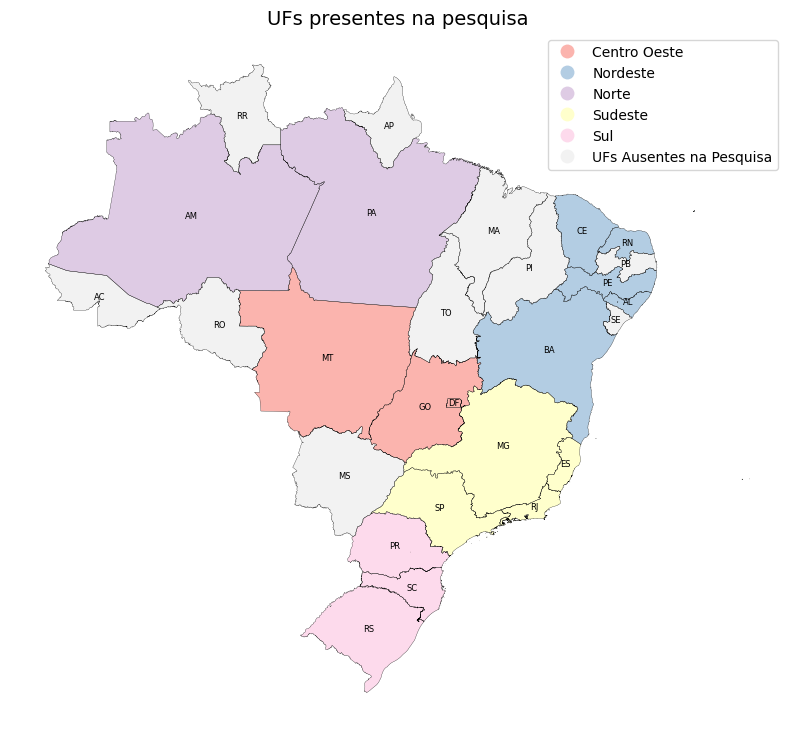

In [353]:
# Plotando

# Criando nova categoria para UF's ausentes
mapa['regiao_y'] = mapa['regiao_y'].fillna('UFs Ausentes na Pesquisa')

fig, ax = plt.subplots(figsize=(10, 14))

mapa.plot(column='regiao_y', cmap='Pastel1', legend=True, ax=ax)
mapa.boundary.plot(ax=ax, color='black', linewidth=0.2)

for idx, row in mapa.iterrows():
    ax.text(row.geometry.centroid.x, row.geometry.centroid.y, row['SIGLA_UF'], ha='center', va='center', fontsize=6)

ax.set_title('UFs presentes na pesquisa', fontsize=14)
ax.set_axis_off()

plt.show()

In [366]:
df_completo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35796 entries, 0 to 3959
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   data           35796 non-null  datetime64[ns]
 1   ano            35796 non-null  int32         
 2   mes            35796 non-null  object        
 3   id_local       35796 non-null  int64         
 4   local          35796 non-null  object        
 5   regiao         35796 non-null  object        
 6   tipo_indice    35796 non-null  object        
 7   tipo_variavel  35796 non-null  object        
 8   valor_indice   35796 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(5)
memory usage: 2.6+ MB


### Índices

In [368]:
# Criando dfs filtrados por Índice
df_num_ind_volume = df_num_ind[df_num_ind['tipo_indice'] == 'Índice de volume das atividades turísticas']
df_num_ind_receita = df_num_ind[df_num_ind['tipo_indice'] == 'Índice de receita nominal das atividades turísticas']


# Pivotando tabelas para facilitar criação de gráficos
df_num_ind_volume = pd.pivot_table(df_num_ind_volume,
                             index=['data', 'ano', 'mes', 'local', 'regiao', 'tipo_indice'],
                             columns='tipo_variavel',
                             values='valor_indice')

df_num_ind_receita = pd.pivot_table(df_num_ind_receita,
                              index=['data', 'ano', 'mes', 'local', 'regiao', 'tipo_indice'],
                              columns='tipo_variavel',
                              values='valor_indice')

df_num_ind_volume.head()
df_num_ind_receita.head()

tipo_variavel                                                                                 Número-índice (2022=100)  \
data       ano  mes     local    regiao   tipo_indice                                                                    
2011-01-01 2011 January Alagoas  Nordeste Índice de receita nominal das atividades turíst...                  46.73047   
                        Amazonas Norte    Índice de receita nominal das atividades turíst...                  58.74847   
                        Bahia    Nordeste Índice de receita nominal das atividades turíst...                  57.84488   
                        Brasil   Brasil   Índice de receita nominal das atividades turíst...                  55.55473   
                        Ceará    Nordeste Índice de receita nominal das atividades turíst...                  50.12370   

tipo_variavel                                                                                 Número-índice com ajuste sazonal (2022=100)  
data       ano  mes     local    regiao   tipo_indice                                                                                      
2011-01-01 2011 January Alagoas  Nordeste Índice de receita nominal das atividades turíst...                                     25.53496  
                        Amazonas Norte    Índice de receita nominal das atividades turíst...                                     59.61469  
                        Bahia    Nordeste Índice de receita nominal das atividades turíst...                                     40.15403  
                        Brasil   Brasil   Índice de receita nominal das atividades turíst...                                     50.08280  
                        Ceará    Nordeste Índice de receita nominal das atividades turíst...                                     36.82552

In [369]:
# Plotando Volume

# Agrupando por número índice
vol_agrupado = df_num_ind_volume.groupby(['data', 'regiao'])[['Número-índice (2022=100)', 'Número-índice com ajuste sazonal (2022=100)']].sum().reset_index()

# Criando Gráficos
indices = [
    "Número-índice (2022=100)",
    "Número-índice com ajuste sazonal (2022=100)",
]

# Criando Gráficos
for indice in indices:
  fig = px.line(
          vol_agrupado.reset_index(),
          x="data",
          y = indice,
          color="regiao",
          markers=True,
          title= f"Volume de Atividades Turísticas por Região: {indice}",
          template="plotly_dark"
          )
  # Removendo titulos dos eixos
  fig.update_xaxes(title_text="")
  fig.update_yaxes(title_text="")
  # Removendo título da legenda
  fig.update_layout(showlegend=True, legend_title_text=None)
  # Centralizando título
  fig.update_layout(title_x=0.5)

  fig.show()

In [370]:
# Plotando Receita

# Agrupando por número índice
rec_agrupado = df_num_ind_receita.groupby(['data', 'regiao'])[['Número-índice (2022=100)', 'Número-índice com ajuste sazonal (2022=100)']].sum().reset_index()

# Criando Gráficos
indices = [
    "Número-índice (2022=100)",
    "Número-índice com ajuste sazonal (2022=100)",
]

for indice in indices:
  fig = px.line(
          rec_agrupado.reset_index(),
          x="data",
          y = indice,
          color="regiao",
          markers=True,
          title= f"Receita de Atividades Turísticas por Região: {indice}",
          template="plotly_dark"
          )
  # Removendo titulos dos eixos
  fig.update_xaxes(title_text="")
  fig.update_yaxes(title_text="")
  # Removendo título da legenda
  fig.update_layout(showlegend=True, legend_title_text=None)
  # Centralizando título
  fig.update_layout(title_x=0.5)

  fig.show()

In [373]:
vol_agrupado_local.head()

tipo_variavel       data     local  Número-índice (2022=100)  \
0             2011-01-01   Alagoas                  67.51036   
1             2011-01-01  Amazonas                 112.14222   
2             2011-01-01     Bahia                 110.13467   
3             2011-01-01    Brasil                 110.23394   
4             2011-01-01     Ceará                  98.34826   

tipo_variavel  Número-índice com ajuste sazonal (2022=100)  
0                                                 47.42919  
1                                                119.36073  
2                                                 86.65778  
3                                                104.61891  
4                                                 81.91205

In [374]:
df_num_ind_volume.head()

tipo_variavel                                                                         Número-índice (2022=100)  \
data       ano  mes     local    regiao   tipo_indice                                                            
2011-01-01 2011 January Alagoas  Nordeste Índice de volume das atividades turísticas                  67.51036   
                        Amazonas Norte    Índice de volume das atividades turísticas                 112.14222   
                        Bahia    Nordeste Índice de volume das atividades turísticas                 110.13467   
                        Brasil   Brasil   Índice de volume das atividades turísticas                 110.23394   
                        Ceará    Nordeste Índice de volume das atividades turísticas                  98.34826   

tipo_variavel                                                                         Número-índice com ajuste sazonal (2022=100)  
data       ano  mes     local    regiao   tipo_indice                                                                              
2011-01-01 2011 January Alagoas  Nordeste Índice de volume das atividades turísticas                                     47.42919  
                        Amazonas Norte    Índice de volume das atividades turísticas                                    119.36073  
                        Bahia    Nordeste Índice de volume das atividades turísticas                                     86.65778  
                        Brasil   Brasil   Índice de volume das atividades turísticas                                    104.61891  
                        Ceará    Nordeste Índice de volume das atividades turísticas                                     81.91205

In [384]:
# Plotando Volume por UF

# Agrupando por número índice
vol_agrupado_local = df_num_ind_volume.groupby(['data', 'local'])[['Número-índice (2022=100)', 'Número-índice com ajuste sazonal (2022=100)']].sum().reset_index()

# Criando Gráficos

indices = [
    "Número-índice (2022=100)",
    "Número-índice com ajuste sazonal (2022=100)",
]

for indice in indices:
  fig = px.line(
          vol_agrupado_local.reset_index(),
          x="data",
          y = indice,
          color="local",
          markers=True,
          title= f"Volume de Atividades Turísticas por UF: {indice}",
          template="plotly_dark"
          )
  # Removendo titulos dos eixos
  fig.update_xaxes(title_text="")
  fig.update_yaxes(title_text="")
  # Removendo título da legenda
  fig.update_layout(showlegend=True, legend_title_text=None)
  # Centralizando título
  fig.update_layout(title_x=0.5)

  fig.show()

## Variações

In [382]:
# Criando dfs filtrados por Variação
df_var_volume = df_var[df_var['tipo_indice'] == 'Índice de volume das atividades turísticas']
df_var_receita = df_var[df_var['tipo_indice'] == 'Índice de receita nominal das atividades turísticas']

# Pivotando tabelas para facilitar criação de gráficos
df_var_volume = pd.pivot_table(df_var_volume,
                         index=['data', 'ano', 'mes', 'id_local', 'local', 'regiao', 'tipo_indice'],
                         columns='tipo_variavel',
                         values='valor_indice')

df_var_receita = pd.pivot_table(df_var_receita,
                          index=['data', 'ano', 'mes', 'id_local', 'local', 'regiao', 'tipo_indice'],
                          columns='tipo_variavel',
                          values='valor_indice')

df_var_volume.head(n=18)
df_var_volume.tail(n=18)
df_var_receita.head(n=18)
df_var_receita.tail(n=18)

tipo_variavel                                                                                                           Variação acumulada em 12 meses (em relação ao período anterior de 12 meses)  \
data       ano  mes       id_local local               regiao       tipo_indice                                                                                                                       
2024-09-01 2024 September 1        Brasil              Brasil       Índice de receita nominal das atividades turíst...                                               11.0                             
                          13       Amazonas            Norte        Índice de receita nominal das atividades turíst...                                               -3.9                             
                          15       Pará                Norte        Índice de receita nominal das atividades turíst...                                               13.5                             
                          23       Ceará               Nordeste     Índice de receita nominal das atividades turíst...                                                7.9                             
                          24       Rio Grande do Norte Nordeste     Índice de receita nominal das atividades turíst...                                                4.9                             
                          26       Pernambuco          Nordeste     Índice de receita nominal das atividades turíst...                                               10.8                             
                          27       Alagoas             Nordeste     Índice de receita nominal das atividades turíst...                                                4.2                             
                          29       Bahia               Nordeste     Índice de receita nominal das atividades turíst...                                               15.7                             
                          31       Minas Gerais        Sudeste      Índice de receita nominal das atividades turíst...                                               18.3                             
                          32       Espírito Santo      Sudeste      Índice de receita nominal das atividades turíst...                                                2.5                             
                          33       Rio de Janeiro      Sudeste      Índice de receita nominal das atividades turíst...                                               12.1                             
                          35       São Paulo           Sudeste      Índice de receita nominal das atividades turíst...                                               11.8                             
                          41       Paraná              Sul          Índice de receita nominal das atividades turíst...                                               11.4                             
                          42       Santa Catarina      Sul          Índice de receita nominal das atividades turíst...                                               12.3                             
                          43       Rio Grande do Sul   Sul          Índice de receita nominal das atividades turíst...                                               -3.5                             
                          51       Mato Grosso         Centro Oeste Índice de receita nominal das atividades turíst...                                               -0.7                             
                          52       Goiás               Centro Oeste Índice de receita nominal das atividades turíst...                                                9.4                             
                          53       Distrito Federal    Centro Oeste Índice de receita nominal das atividades turíst...                                                8.5                             

tipo_variavel      

In [385]:
# Plotando Volume

# Agrupando por número índice
vol_agrupado_2 = df_var_volume.groupby(['data', 'local'])[['Variação mês/mês imediatamente anterior, com ajuste sazonal (M/M-1)',
                                                           'Variação mês/mesmo mês do ano anterior (M/M-12)',
                                                           'Variação acumulada no ano (em relação ao mesmo período do ano anterior)',
                                                           'Variação acumulada em 12 meses (em relação ao período anterior de 12 meses)']].sum().reset_index()

# Criando Gráficos
variacoes = [
    'Variação mês/mês imediatamente anterior, com ajuste sazonal (M/M-1)',
    'Variação mês/mesmo mês do ano anterior (M/M-12)',
    'Variação acumulada no ano (em relação ao mesmo período do ano anterior)',
    'Variação acumulada em 12 meses (em relação ao período anterior de 12 meses)'
]

# Criando Gráficos
for variacao in variacoes:
  fig = px.line(
          vol_agrupado_2.reset_index(),
          x="data",
          y = variacao,
          color="local",
          markers=True,
          title= f"Volume de Atividades Turísticas por UF: {variacao}",
          template="plotly_dark"
          )
  # Removendo titulos dos eixos
  fig.update_xaxes(title_text="")
  fig.update_yaxes(title_text="")
  # Removendo título da legenda
  fig.update_layout(showlegend=True, legend_title_text=None)
  # Centralizando título
  fig.update_layout(title_x=0.5)

  fig.show()

In [389]:
df_completo.head()

data   ano      mes  id_local     local regiao  \
0  2011-01-01  2011  January        13  Amazonas  Norte   
1  2011-01-01  2011  January        13  Amazonas  Norte   
2  2011-01-01  2011  January        13  Amazonas  Norte   
3  2011-01-01  2011  January        13  Amazonas  Norte   
12 2011-01-01  2011  January        15      Pará  Norte   

                                          tipo_indice  \
0   Índice de receita nominal das atividades turís...   
1          Índice de volume das atividades turísticas   
2   Índice de receita nominal das atividades turís...   
3          Índice de volume das atividades turísticas   
12  Índice de receita nominal das atividades turís...   

                                  tipo_variavel  valor_indice  
0                      Número-índice (2022=100)      58.74847  
1                      Número-índice (2022=100)     112.14222  
2   Número-índice com ajuste sazonal (2022=100)      59.61469  
3   Número-índice com ajuste sazonal (2022=100)     119.36073  
12                     Número-índice (2022=100)      37.68129

In [394]:
# Comparando volume de atividade em MG x Brasil
df_mg_x_br = df_completo[(df_completo['local'] == 'Minas Gerais') | (df_completo['local'] == 'Brasil')]

df_mg_x_br = pd.pivot_table(df_mg_x_br,
                         index=['data', 'ano', 'mes', 'id_local', 'local', 'regiao', 'tipo_indice'],
                         columns='tipo_variavel',
                         values='valor_indice')

vol_agrupado_3 = df_mg_x_br.groupby(['data', 'local'])[['Variação mês/mês imediatamente anterior, com ajuste sazonal (M/M-1)',
                                                        'Variação mês/mesmo mês do ano anterior (M/M-12)',
                                                        'Variação acumulada no ano (em relação ao mesmo período do ano anterior)',
                                                        'Variação acumulada em 12 meses (em relação ao período anterior de 12 meses)']].sum().reset_index()






# Criando Gráficos
variacoes = [
    'Variação mês/mês imediatamente anterior, com ajuste sazonal (M/M-1)',
    'Variação mês/mesmo mês do ano anterior (M/M-12)',
    'Variação acumulada no ano (em relação ao mesmo período do ano anterior)',
    'Variação acumulada em 12 meses (em relação ao período anterior de 12 meses)'
]

# Criando Gráficos
for variacao in variacoes:
  vol_agrupado_3[f"text_{variacao}"] = vol_agrupado_3[variacao].round(2)
  fig = px.bar(
          vol_agrupado_3.reset_index(),
          x="data",
          y = variacao,
          color="local",
          title= f"Volume de Atividades Turísticas por MG x Brasil: {variacao}",
          template="plotly_dark",
          text = variacao,
          barmode='group'
          )
  # Removendo titulos dos eixos
  fig.update_xaxes(title_text="")
  fig.update_yaxes(title_text="")
  # Removendo título da legenda
  fig.update_layout(showlegend=True, legend_title_text=None)
  # Centralizando título
  fig.update_layout(title_x=0.5)
  fig.update_traces(textposition='outside')

  fig.show()

# Análise de caso: COSUD


---


O Consórcio de Integração Sul e Sudeste (Cosud) foi criado em 2019 com o objetivo de fortalecer a cooperação entre os Governos de ambas as regiões e, assim, impulsionar ações socioeconômicas nas áreas de meio ambiente, segurança pública, assistência social, cultura, infraestrutura, saúde, esporte, turismo, mobilidade, educação, desenvolvimento econômico, inovação, tecnologia e eficiência na gestão.

Seus sete Estados (São Paulo, Rio de Janeiro, Espírito Santo, Minas Gerais, Rio Grande do Sul, Paraná e Santa Catarina) acolhem mais de 114 milhões de habitantes, o que corresponde a 56,5% da população do país. Além disso, representam 70% do Produto Interno Bruto (PIB) nacional, segundo dados do Instituto Brasileiro de Geografia e Estatística (IBGE).

> [Referências](https://sefaz.es.gov.br/Not%C3%ADcia/governadores-do-sul-e-sudeste-assinam-carta-com-intencoes-comuns-entre-os-estados#:~:text=Sobre%20o%20Cosud&text=Seus%20sete%20Estados%20(S%C3%A3o%20Paulo,56%2C5%25%20da%20popula%C3%A7%C3%A3o.)



In [36]:
# Filtrando estados do COSUD
cosud = pd.Series(["Sul", "Sudeste"])

df_cosud = df[df['regiao'].isin(cosud)]

In [37]:
df_cosud.head()

ano      mes  id_uf              uf   regiao  \
84  2011  janeiro     31    Minas Gerais  Sudeste   
85  2011  janeiro     31    Minas Gerais  Sudeste   
86  2011  janeiro     31    Minas Gerais  Sudeste   
87  2011  janeiro     31    Minas Gerais  Sudeste   
96  2011  janeiro     32  Espírito Santo  Sudeste   

                                          tipo_indice  \
84  Índice de receita nominal das atividades turís...   
85         Índice de volume das atividades turísticas   
86  Índice de receita nominal das atividades turís...   
87         Índice de volume das atividades turísticas   
96  Índice de receita nominal das atividades turís...   

                                  tipo_variavel  valor_indice  
84                     Número-índice (2022=100)      44.12214  
85                     Número-índice (2022=100)      78.75757  
86  Número-índice com ajuste sazonal (2022=100)      42.97915  
87  Número-índice com ajuste sazonal (2022=100)      79.26826  
96                     Número-índice (2022=100)      56.69158

In [38]:
df_cosud['tipo_variavel'].value_counts()

tipo_variavel
Número-índice (2022=100)                                                       2310
Número-índice com ajuste sazonal (2022=100)                                    2310
Variação mês/mês imediatamente anterior, com ajuste sazonal (M/M-1)            2296
Variação mês/mesmo mês do ano anterior (M/M-12)                                2142
Variação acumulada no ano (em relação ao mesmo período do ano anterior)        2142
Variação acumulada em 12 meses (em relação ao período anterior de 12 meses)    1988
Name: count, dtype: int64

In [39]:
df_cosud['tipo_indice'].unique()

array(['Índice de receita nominal das atividades turísticas',
       'Índice de volume das atividades turísticas'], dtype=object)

In [40]:
# Preparando df_cosud para criar os gráficos

# Filtrando
variaveis_desejadas = [
    "Variação mês/mês imediatamente anterior, com ajuste sazonal (M/M-1)",
    "Variação mês/mesmo mês do ano anterior (M/M-12)",
    "Variação acumulada no ano (em relação ao mesmo período do ano anterior)",
    "Variação acumulada em 12 meses (em relação ao período anterior de 12 meses)",
]

df_filtrado = df_cosud[df_cosud["tipo_variavel"].isin(variaveis_desejadas)]

# Alterando o nome do tipo da variável
mapeamento_tipo_indice = {
    "Índice de volume das atividades turísticas": "Volume",
    "Índice de receita nominal das atividades turísticas": "Receita Nominal",
}

df_filtrado = df_cosud[df_cosud["tipo_variavel"].isin(variaveis_desejadas)].copy()
df_filtrado["tipo_indice"] = df_filtrado["tipo_indice"].map(mapeamento_tipo_indice)

# Ordenamento cronológico dos meses
meses_ordem = [
    "janeiro",
    "fevereiro",
    "março",
    "abril",
    "maio",
    "junho",
    "julho",
    "agosto",
    "setembro",
    "outubro",
    "novembro",
    "dezembro",
]

df_filtrado["mes"] = pd.Categorical(df_filtrado["mes"], categories=meses_ordem, ordered=True)



In [41]:
# Criando gráficos interativos para visualizar os indíces por tipo de índice, tipo de variável e UF
for variavel in variaveis_desejadas:
    fig = px.bar(
        df_filtrado[df_filtrado["tipo_variavel"] == variavel],
        x="ano",
        y="valor_indice",
        color="uf",
        barmode="group",
        animation_frame="mes",
        facet_col="tipo_indice",
        title=f"IATUR (2011 a 2024/09) - COSUD - {variavel}",
        labels = "valor_indice",
        template="plotly_dark"
    )

    # Removendo titulos dos eixos
    fig.update_xaxes(title_text="")
    fig.update_yaxes(title_text="")

    # Removendo título da legenda
    fig.update_layout(showlegend=True, legend_title_text=None)

    # Centralizando título
    fig.update_layout(title_x=0.5)

    # Alterar texto acima de cada gráfico
    for annotation in fig["layout"]["annotations"]:
        if annotation["text"].startswith("tipo_indice="):
            annotation["text"] = annotation["text"].replace(
                "tipo_indice=", ""
            )  # Remover "tipo_indice="


    fig.show()

#### Redigir texto comentando gráficos e comparação de períodos